# Work Flow

<img src="work-flow.jpg" alt='wrok flow'/>

# Libraries 

In [1]:
import numpy as np
import pandas as pd

# Datasets

In [2]:
# for the label and unlabel datasets
lab_dataset = pd.read_csv('Final_ToBeLabelled(ICD_INCLUDED)_EN.csv', sep='\t')
unlab_dataset = pd.read_csv('Final_Unlabelled_EN.csv', sep='\t')
# split labelled datasets into X and y
X_lab = pd.read_csv('Final_ToBeLabelled(ICD_INCLUDED)_EN.csv', sep='\t').drop(labels=['ICD','index_exam'], axis =1)
y_lab = pd.read_csv('Final_ToBeLabelled(ICD_INCLUDED)_EN.csv', sep='\t')['ICD'].astype('category') # as category 
# split Unlabelled datasets into X and y
X_unlab = pd.read_csv('Final_Unlabelled_EN.csv', sep='\t').drop(labels=['ICD','index_exam'], axis =1)
y_unlab = pd.read_csv('Final_Unlabelled_EN.csv', sep='\t')['ICD']

In [3]:
# Size of the dataset before preprocessing 
lab_dataset.shape, unlab_dataset.shape, X_lab.shape,X_unlab.shape, y_unlab.shape, y_lab.shape

((192, 17), (17174, 17), (192, 15), (17174, 15), (17174,), (192,))

# Preprocessing

In [4]:
# preprocessing on X_lab and X_unlab (label encoding)
X_sex = pd.get_dummies(data=X_lab['Weiblich/Männlich'])
X_unlab_sex = pd.get_dummies(data=X_unlab['Weiblich/Männlich'])
X_age = pd.get_dummies(data=X_lab['age'])
X_unlab_age = pd.get_dummies(data=X_unlab['age'])
# drop the UUID, age and sex columns from the data
X_unlab.drop(labels=['UUID', 'age','Weiblich/Männlich'], axis=1, inplace=True)
X_lab.drop(labels=['age','Weiblich/Männlich', 'UUID'],axis=1,inplace=True)
# after the preprocessing,instantiate call it X_train
X_lab_p = pd.concat([X_sex,X_age,X_lab],axis=1).astype('float')
# after the preprocessing,instantiate call it X_unlab_p
X_unlab_p = pd.concat([X_unlab_sex,X_unlab_age,X_unlab],axis=1).astype('float')
# summarize training set size
print('Labeled Set After Preprocessing:', X_lab_p.shape, y_lab.shape)
# summarize Unlabeled set size
print('Unlabeled Set After Preprocessing:', X_unlab_p.shape, y_unlab.shape)

Labeled Set After Preprocessing: (192, 22) (192,)
Unlabeled Set After Preprocessing: (17174, 22) (17174,)


A `supervised` learning algorithm will only have 192 rows from which to train a model.

A `semi-supervised` learning algorithm will have the 17174 labeled rows as well as the 17174 unlabeled rows that could be used in numerous ways to improve the labeled training dataset.

Next, we can establish a baseline in performance on the semi-supervised learning dataset using a supervised learning algorithm fit only on the labeled training data.

This is important because we would expect a semi-supervised learning algorithm to outperform a supervised learning algorithm fit on the labeled data alone. If this is not the case, then the semi-supervised learning algorithm does not have skill.

In this case, we will use a `support vector machine` algorithm fit on the labeled portion of the training dataset. <br>
Then, a subset of the patients with High and Low is  drawn by `Experts`

# Model

In [5]:
# Semi-supervised approach to label the other patients 
# warning ⚠ 
import warnings
warnings.filterwarnings('ignore')
# scale our dataset
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit_transform(X_lab_p)
# Using the Transductive Support Machine (S3VM)
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier
# using the Self Learning Framework
base_model = SVC(kernel='linear', probability=True, C=1)
ssmodel = SelfTrainingClassifier(base_estimator=base_model)
# model learning
ssmodel.fit(X_lab_p,y_lab)

SelfTrainingClassifier(base_estimator=SVC(C=1, kernel='linear',
                                          probability=True))

The model can then be used to make predictions on the entire `Unlabeled` dataset and evaluated using classification accuracy.

In [6]:
# make predictions on Unlabeled dataset
# scale the unlabeled dataset
scale.transform(X_unlab_p)
yhat = ssmodel.predict_proba(X_unlab_p)
label = ssmodel.predict(X_unlab_p)

In [7]:
yhat[:10]

array([[0.00469109, 0.00490869, 0.00398537, ..., 0.00450686, 0.0030542 ,
        0.00331667],
       [0.00419838, 0.0046785 , 0.00505702, ..., 0.0042389 , 0.00345515,
        0.00267962],
       [0.00500645, 0.00436134, 0.00473257, ..., 0.00484745, 0.00346903,
        0.00325788],
       ...,
       [0.00533741, 0.00405999, 0.00451788, ..., 0.00508246, 0.00345774,
        0.00340183],
       [0.00461823, 0.00429676, 0.0048435 , ..., 0.00449491, 0.00341922,
        0.00336664],
       [0.00395535, 0.00296835, 0.00514417, ..., 0.00336367, 0.00348706,
        0.00300571]])

# Confidence

In [8]:
df = pd.DataFrame(yhat, columns=y_lab[:])
df.head()

ICD,G58.0,M48.00,M18.0,M24.68,M42.97,M54.99,G56.9,M40.50,M93.9,S13.4,...,M79.18,M75.3,M51.2,M40.56,M41.00,Q66.8,M40.46,M40.24,M17.0,M62.48
0,0.004691,0.004909,0.003985,0.008582,0.003719,0.005263,0.004120,0.004460,0.005724,0.004992,...,0.004659,0.004912,0.003805,0.006039,0.003907,0.003578,0.006863,0.004507,0.003054,0.003317
1,0.004198,0.004678,0.005057,0.010600,0.004828,0.003711,0.003250,0.003088,0.003774,0.004014,...,0.004005,0.003563,0.004514,0.005507,0.003003,0.003260,0.008414,0.004239,0.003455,0.002680
2,0.005006,0.004361,0.004733,0.008775,0.005033,0.005263,0.003934,0.004284,0.004310,0.005040,...,0.004105,0.004388,0.004325,0.005213,0.004080,0.004308,0.006425,0.004847,0.003469,0.003258
3,0.004228,0.004469,0.005366,0.008991,0.004961,0.004624,0.003646,0.003602,0.003890,0.004216,...,0.004395,0.004101,0.004394,0.005824,0.003558,0.003571,0.007300,0.004232,0.003695,0.002913
4,0.005027,0.004399,0.004043,0.007286,0.003950,0.006373,0.004527,0.005106,0.005917,0.005474,...,0.004671,0.005527,0.003608,0.006034,0.004549,0.004355,0.005555,0.004781,0.003150,0.003609


In [9]:
# maximum value predicted for each label
high_value = df[df.columns].max(axis=1)
low_value = df[df.columns].min(axis=1)
high_value = pd.DataFrame(data=high_value, columns=['High_Value'])
low_value = pd.DataFrame(data=low_value, columns=['Low_Value'])
# dataframe of the predicted Label
df_l = pd.DataFrame(data=label, columns=['Predicted Labels'])
# DataFrame of the Maximum probabiliy of predicting each label and the Label that was predicted...
df_la_max =pd.concat([df_l,high_value,low_value, df], axis=1)
df_la_max.sample(frac=.2)

,Predicted Labels,High_Value,Low_Value,G58.0,M48.00,M18.0,M24.68,M42.97,M54.99,G56.9,...,M79.18,M75.3,M51.2,M40.56,M41.00,Q66.8,M40.46,M40.24,M17.0,M62.48
4529,M77.4,0.011511,0.003181,0.004306,0.004330,0.004765,0.006721,0.004254,0.006335,0.004328,...,0.004895,0.005530,0.003835,0.006750,0.004134,0.003873,0.005498,0.004167,0.003566,0.003223
14388,M25.51,0.015672,0.002949,0.003876,0.003647,0.004708,0.005926,0.003829,0.007016,0.004497,...,0.005085,0.006092,0.003306,0.007374,0.004084,0.003637,0.004657,0.003764,0.003446,0.003184
12821,M40.30,0.010672,0.002659,0.004569,0.004075,0.005877,0.007398,0.004632,0.004995,0.004569,...,0.004699,0.005162,0.003885,0.008059,0.003115,0.003501,0.006428,0.003886,0.003804,0.003231
17097,M54.5,0.036802,0.002012,0.002895,0.002052,0.004886,0.003478,0.003230,0.006615,0.004473,...,0.004779,0.006622,0.002177,0.008964,0.003129,0.002893,0.002694,0.002411,0.003195,0.002677
1416,M41.95,0.010566,0.003011,0.005253,0.004059,0.004525,0.007073,0.004905,0.006807,0.004440,...,0.004294,0.005265,0.003974,0.005713,0.004515,0.004900,0.004938,0.004934,0.003442,0.003461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,M25.5-,0.014368,0.002748,0.005690,0.004597,0.003605,0.008976,0.004587,0.006351,0.004011,...,0.003645,0.004626,0.003916,0.004415,0.004686,0.004934,0.005492,0.005358,0.002836,0.003401
6420,M20.1,0.012654,0.003047,0.004673,0.004561,0.005217,0.008412,0.004779,0.004883,0.003927,...,0.004431,0.004747,0.004128,0.006469,0.003660,0.003773,0.006820,0.004348,0.003504,0.003192
3903,M94.26,0.023311,0.002538,0.004868,0.004795,0.003398,0.012855,0.004415,0.003771,0.002831,...,0.002936,0.003005,0.004311,0.003657,0.003205,0.003676,0.007497,0.004985,0.002582,0.002622
11934,M92.5,0.012999,0.002803,0.003991,0.004623,0.005749,0.008772,0.004938,0.004243,0.003582,...,0.004651,0.004200,0.004499,0.006453,0.003267,0.003254,0.007653,0.003968,0.003878,0.002803


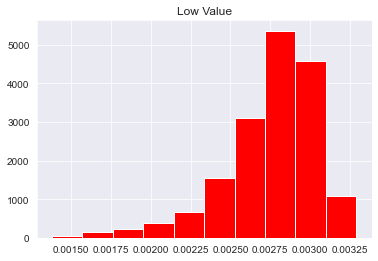

In [10]:
# visualization librarie
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
# distribution of the maximum value
plt.hist(df_la_max['Low_Value'], color='r')
plt.title('Low Value')
plt.show()

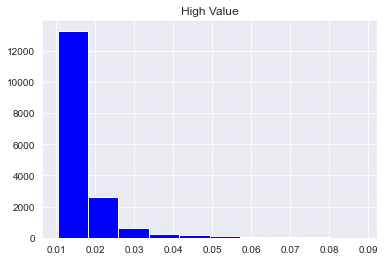

In [11]:
plt.hist(df_la_max['High_Value'], color='b')
plt.title('High Value')
plt.show()

# Next

##### A subset of the Patient with `High` and `Low` is drawn by the Experts